In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

import sys, importlib
from FetchModel import FetchModel
from PostPred import PostPred
importlib.reload(sys.modules['FetchModel'])
importlib.reload(sys.modules['PostPred'])
from FetchModel import FetchModel
from PostPred import PostPred

In [202]:
Y = pd.read_csv("../Datasets/Dataset_180.csv")
Y['Count_180'] = pd.to_numeric(Y['Count_180']).astype('Int64')
X = pd.read_csv("../Datasets/variables_to_select.csv")
X_raw = pd.read_csv("../Datasets/covariates.csv")

In [203]:
idx_obs = Y[Y['Count_180'].notna()].index
idx_miss = Y[Y['Count_180'].isna()].index

Y_obs = Y.loc[idx_obs, :].reset_index(drop=True)
Y_miss = Y.loc[idx_miss, :].reset_index(drop=True)

X_obs = X.loc[idx_obs, :].reset_index(drop=True)
X_miss = X.loc[idx_miss, :].reset_index(drop=True)

In [204]:
stations = Y['idSensore']
years = pd.Series(Y['Year'] - 2009)
months = pd.Series(Y['Month'] - 3)
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]
stations_original = pd.Series(stations)
stations = pd.Series(transformed_stations)

stations_obs = stations.loc[idx_obs].reset_index(drop=True)
stations_miss = stations.loc[idx_miss].reset_index(drop=True)
years_obs = years.loc[idx_obs].reset_index(drop=True)
years_miss = years.loc[idx_miss].reset_index(drop=True)
months_obs = months.loc[idx_obs].reset_index(drop=True)
months_miss = months.loc[idx_miss].reset_index(drop=True)


day_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]

max_month = [day_in_month[Y['Month'][i]-1] for i in range(0,Y.shape[0]) ]

max_month = pd.Series(max_month)
max_month_obs = max_month.loc[idx_obs].reset_index(drop=True)
max_month_miss = max_month.loc[idx_miss].reset_index(drop=True)

In [205]:
Model_metrics = pd.DataFrame(columns=['WAIC', 'LOO', 'MSE', 'MAE', 'MAD', 'inside CI'])

# Base Model

In [206]:
model_base  = FetchModel("base").compile()

19:46:03 - cmdstanpy - INFO - compiling stan file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\base.stan to exe file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\base.exe
19:46:48 - cmdstanpy - INFO - compiled model executable: C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\base.exe


In [207]:
data_base = {
    "N": len(Y_obs),
    "P": X_obs.shape[1],
    "y": Y_obs['Count_180'],
    "X": X_obs
}

fit_base = model_base.sample(data=data_base, chains=4, parallel_chains=4, 
    iter_warmup=200, iter_sampling=300)
posterior_180_base = az.from_cmdstanpy(fit_base)

19:46:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:47:05 - cmdstanpy - INFO - CmdStan done processing.


In [208]:
post_pred = PostPred(posterior_180_base, Y['Count_180'])
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

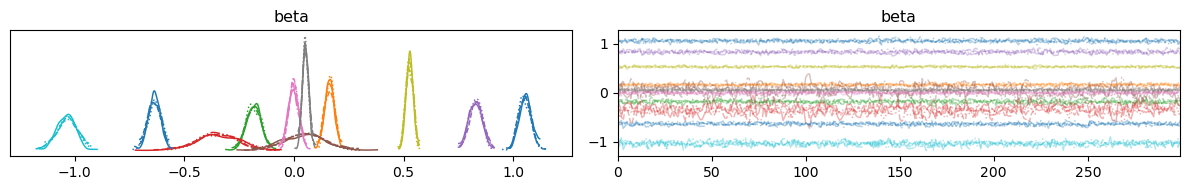

In [209]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta'])
plt.tight_layout()
plt.show()

In [210]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 1200 posterior samples and 3808 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -5432.83   117.48
p_waic       37.42        -

There has been a warning during the calculation. Please check the results.
Computed from 1200 posterior samples and 3808 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -5432.96   117.48
p_loo       37.54        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3808  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [211]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [212]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

Outliers:
[   2    3   36   37   51   74   84   85  100  150  155  193  225  238
  324  330  331  346  347  372  376  378  383  384  389  390  402  403
  422  428  475  516  523  566  580  587  599  600  601  602  607  613
  620  621  622  628  634  636  642  643  648  649  656  676  677  723
  753  766  778  791  798  829  835  851  867  872  873  874  907  914
  925  926  931  944  950  955  956  957  963  969  970  977  983  990
  991  992  998 1038 1049 1050 1063 1064 1065 1070 1071 1072 1077 1093
 1094 1112 1113 1114 1122 1126 1128 1133 1134 1135 1156 1168 1183 1202
 1203 1204 1217 1218 1366 1379 1380 1392 1419 1427 1468 1539 1545 1558
 1559 1560 1566 1568 1571 1572 1573 1574 1580 1581 1582 1658 1710 1715
 1716 1742 1743 1749 1761 1768 1773 1774 1779 1780 1781 1794 1800 1821
 1832 1854 1867 1878 1908 1921 1935 2031 2045 2051 2052 2068 2074 2080
 2081 2082 2093 2094 2095 2107 2108 2110 2127 2135 2136 2152 2158 2165
 2171 2192 2193 2216 2240 2295 2314 2318 2331 2338 2342 2344 2349 2

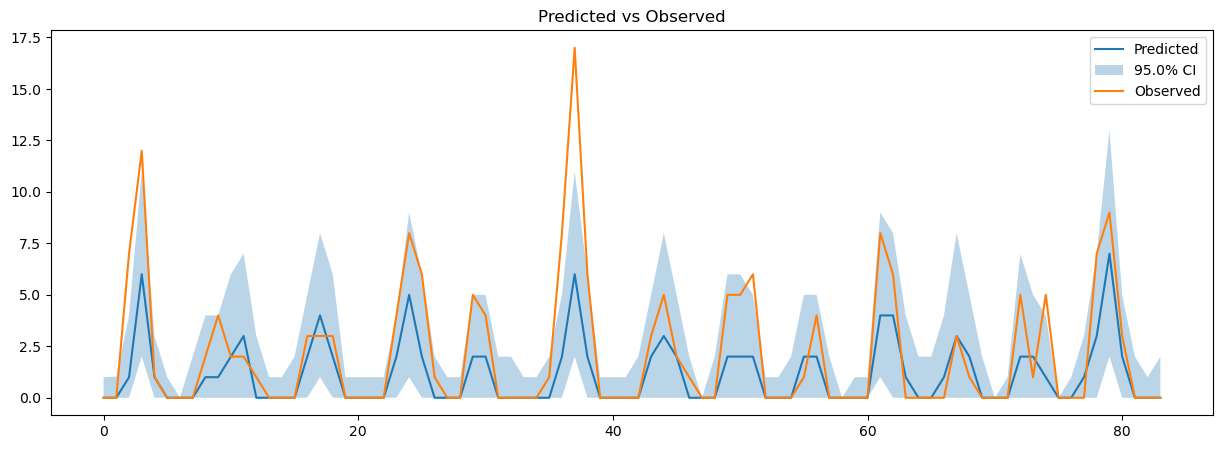

In [213]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()


In [214]:
Model_metrics.loc['Base',:] = [waic, loo, mse, mae, mad, percentage_inside]
print(Model_metrics)

            WAIC          LOO       MSE       MAE  MAD inside CI
Base -5432.83397 -5432.955864  5.283942  1.174238  0.0  0.917542


# Year model
We add the factor accounting for different years.

In [215]:
model_years = FetchModel("years").compile()

19:47:34 - cmdstanpy - INFO - compiling stan file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\years.stan to exe file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\years.exe
19:48:21 - cmdstanpy - INFO - compiled model executable: C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\years.exe


In [216]:
data_years = {
    "N": len(Y_obs),
    "P": X_obs.shape[1],
    "nyears": 13,
    "year": years_obs,
    "y": Y_obs['Count_180'],
    "X": X_obs
}

fit_years = model_years.sample(data=data_years, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_180_years = az.from_cmdstanpy(fit_years)

19:48:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:48:43 - cmdstanpy - INFO - CmdStan done processing.


In [217]:
post_pred = PostPred(posterior_180_years, Y['Count_180'])
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

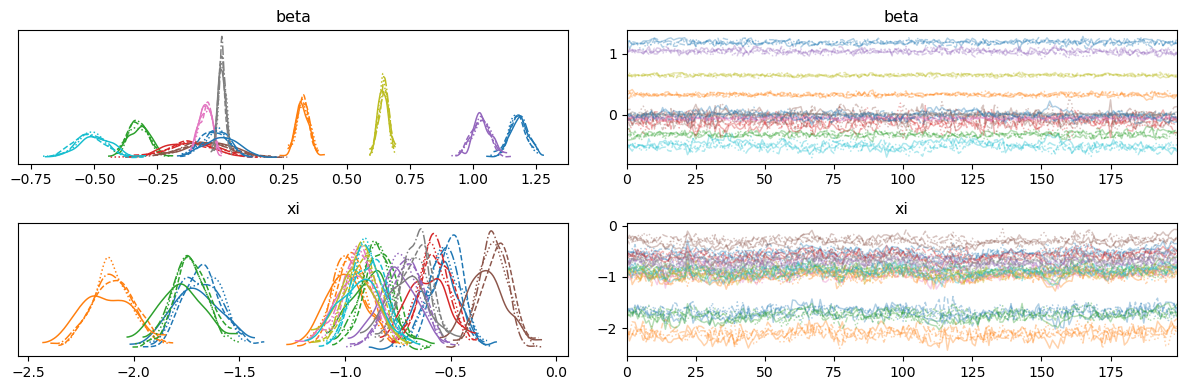

In [218]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi'])
plt.tight_layout()
plt.show()

In [219]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -4815.31   110.87
p_waic       64.77        -

There has been a warning during the calculation. Please check the results.
Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -4815.72   110.90
p_loo       65.19        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3807  100.0%
 (0.5, 0.7]   (ok)          1    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [220]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [221]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

Outliers:
[   2    9   72   74   78  125  150  193  205  233  238  259  299  324
  330  337  339  346  347  371  372  378  383  384  390  402  403  415
  428  435  449  463  516  523  593  596  600  601  602  607  613  620
  621  622  628  630  642  643  644  649  656  658  676  723  778  779
  798  851  867  872  873  913  914  925  931  932  943  944  945  950
  955  956  957  963  969  970  990  991  998 1038 1050 1077 1084 1093
 1094 1112 1114 1119 1120 1122 1128 1133 1134 1135 1156 1157 1168 1183
 1262 1366 1427 1448 1539 1558 1559 1560 1566 1568 1571 1574 1580 1581
 1582 1627 1632 1658 1780 1794 1800 1820 1821 1878 1935 1963 1976 1995
 1996 2010 2011 2051 2052 2068 2074 2080 2081 2082 2094 2095 2107 2108
 2110 2115 2127 2128 2130 2135 2139 2152 2158 2171 2193 2216 2240 2248
 2269 2314 2331 2338 2344 2350 2363 2371 2384 2389 2440 2449 2473 2479
 2552 2553 2559 2561 2562 2563 2566 2567 2568 2569 2575 2586 2621 2646
 2647 2649 2650 2670 2672 2680 2699 2705 2726 2757 2808 2824 2843 2

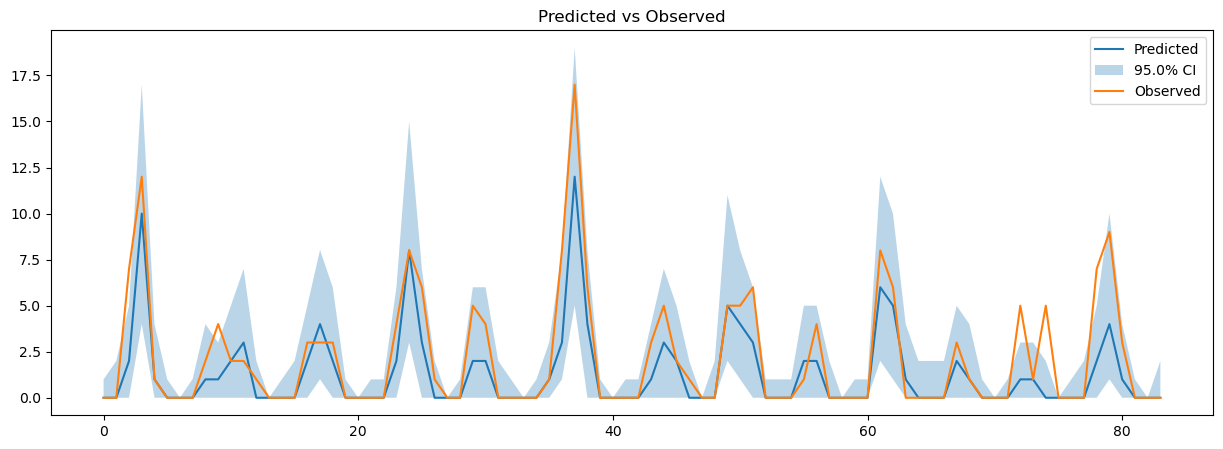

In [222]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()

In [223]:
Model_metrics.loc['Years',:] = [waic, loo, mse, mae, mad, percentage_inside]
print(Model_metrics)

              WAIC          LOO       MSE       MAE  MAD inside CI
Base   -5432.83397 -5432.955864  5.283942  1.174238  0.0  0.917542
Years -4815.305727  -4815.71997  4.036239  0.997111  0.0  0.933298


# Stations factor

After this upgrade, we account for the differences in the *stations* factor.

In [224]:
model_stations = FetchModel("stations").compile()

19:49:13 - cmdstanpy - INFO - compiling stan file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\stations.stan to exe file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\stations.exe
19:50:01 - cmdstanpy - INFO - compiled model executable: C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\stations.exe


In [225]:
data_stations = {
    "N": len(Y_obs),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "stations": stations_obs,
    "year": years_obs,
    "y": Y_obs['Count_180'],
    "X": X_obs
}

fit_stations = model_stations.sample(data=data_stations, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_180_stations = az.from_cmdstanpy(fit_stations)

19:50:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:52:25 - cmdstanpy - INFO - CmdStan done processing.


19:52:26 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 2 iterations at max treedepth (1.0%)
	Chain 2 had 1 iterations at max treedepth (0.5%)
	Use function "diagnose()" to see further information.


In [226]:
post_pred = PostPred(posterior_180_stations, Y['Count_180'])
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

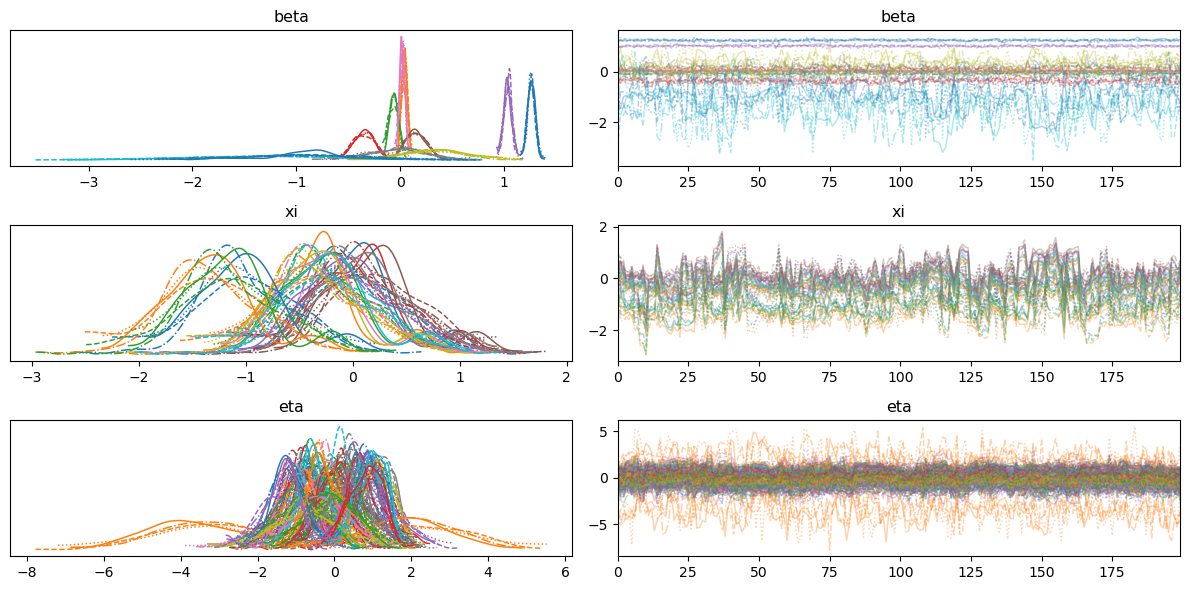

In [227]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'eta'])
plt.tight_layout()
plt.show()

In [228]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -3838.95    85.24
p_waic      108.55        -

There has been a warning during the calculation. Please check the results.
Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -3839.78    85.27
p_loo      109.38        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3805   99.9%
 (0.5, 0.7]   (ok)          2    0.1%
   (0.7, 1]   (bad)         1    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [229]:
eta = post_pred.posterior.eta
eta
len(np.unique(stations))

45

In [230]:
lam = post_pred.posterior['lambda']

In [231]:
inference = []
for i in range(len(np.unique(stations_obs))):
    ar1 = eta[0, :, i]
    ar2 = eta[1, :, i]
    ar3 = eta[2, :, i]
    ar4 = eta[3, :, i]
    current_iteration_df = np.concatenate((ar1, ar2, ar3, ar4), axis=0)
    inference.append(current_iteration_df)

len(current_iteration_df)
len(inference)

45

In [232]:
inference_lam = []
for i in range(len(Y_obs['Count_180'])):
    ar1 = lam[0, :, i]-Y_obs['Count_180'][i]
    ar2 = lam[1, :, i]-Y_obs['Count_180'][i]
    ar3 = lam[2, :, i]-Y_obs['Count_180'][i]
    ar4 = lam[3, :, i]-Y_obs['Count_180'][i]
    current_iteration_df = np.concatenate((ar1, ar2, ar3, ar4), axis=0)
    inference_lam.append(current_iteration_df)

In [233]:
df = pd.DataFrame(inference).transpose()
df.shape
df.columns = np.unique(stations_original[idx_obs])
df.columns.values

array([ 5707,  5710,  5717,  5718,  5719,  5721,  5725,  5730,  5732,
        5735,  5738,  5739,  5742,  5749,  5750,  5952,  5960,  6582,
        6665,  6691,  6804,  6818,  6832,  6884,  6904,  9856,  9861,
        9882,  9899,  9925,  9972,  9991,  9997, 10025, 10041, 10081,
       10171, 10270, 10282, 10288, 10437, 10454, 10463, 10584, 12020],
      dtype=int64)

In [234]:
df = pd.DataFrame(inference_lam).transpose()
df.shape
df.columns.values

array([   0,    1,    2, ..., 3805, 3806, 3807], dtype=int64)

In [235]:
import os
if not os.path.exists('../Datasets/Space_estimate'):
    os.makedirs('../Datasets/Space_estimate')

csv_path = '../Datasets/Space_estimate/eta_180.csv'
data = pd.DataFrame(df)
data.to_csv(csv_path, index=False)

csv_path = '../Datasets/Space_estimate/res_180.csv'
data = pd.DataFrame(df)
data.to_csv(csv_path, index=False)

In [236]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [237]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

Outliers:
[  74  125  150  160  187  193  233  347  365  372  384  402  403  441
  474  475  529  579  602  656  675  676  677  778  798  872  873  907
 1043 1093 1122 1156 1157 1262 1279 1337 1366 1380 1427 1524 1532 1539
 1568 1618 1619 1658 1702 1748 1780 1813 1821 1832 1878 1973 2110 2127
 2135 2179 2224 2240 2331 2338 2350 2371 2377 2384 2389 2440 2449 2458
 2492 2518 2532 2552 2561 2562 2569 2650 2672 2679 2691 2705 2725 2738
 2750 2769 2817 2822 2829 2851 2877 2879 2911 2979 2997 2999 3030 3044
 3087 3100 3220 3222 3226 3227 3260 3272 3330 3400 3401 3443 3486 3507
 3560 3610 3626 3663 3668 3723 3743 3770]

The total number of outliers is: 120

The MSE is: 2.234965861344538

The MAE is: 0.7167804621848739

The MAD is: 0.0

The percentage of observations inside the CI is: 0.9684873949579832



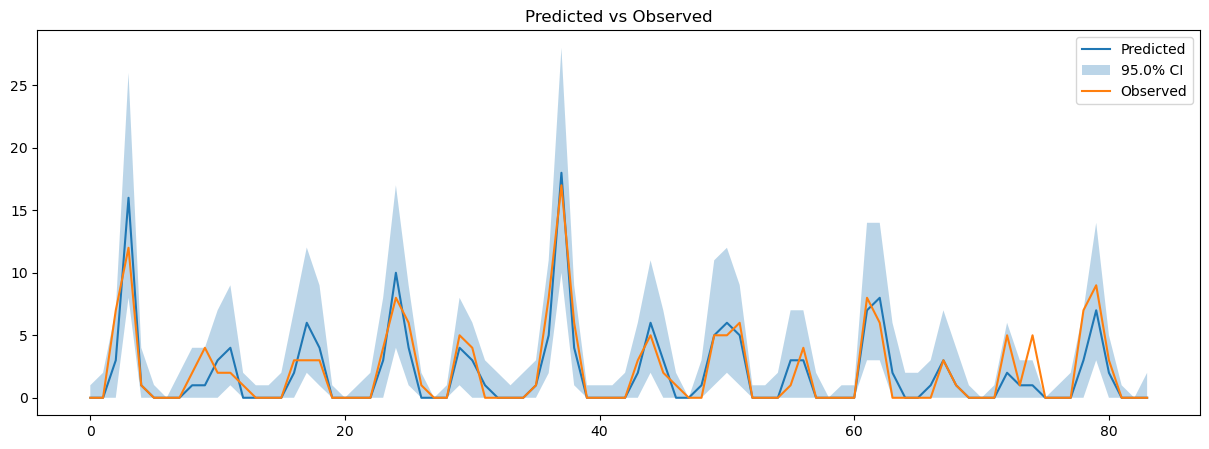

In [238]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()


In [239]:
Model_metrics.loc['Stations',:] = [waic, loo, mse, mae, mad, percentage_inside]
print(Model_metrics)

                 WAIC          LOO       MSE       MAE  MAD inside CI
Base      -5432.83397 -5432.955864  5.283942  1.174238  0.0  0.917542
Years    -4815.305727  -4815.71997  4.036239  0.997111  0.0  0.933298
Stations -3838.954906 -3839.784293  2.234966   0.71678  0.0  0.968487


# Space model

Now, we should take into account the spatial dependance of the model, through an appropriate space model (main folder with R files) and put again this ideas into this model.

In [240]:
phi = 63
distances = pd.read_csv("../Datasets/distances.csv", index_col=0)

In [241]:
model_space = FetchModel("space").compile()

19:52:56 - cmdstanpy - INFO - compiling stan file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\space.stan to exe file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\space.exe
19:53:54 - cmdstanpy - INFO - compiled model executable: C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\space.exe


In [242]:
data_space = {
    "N": len(Y_obs),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "stations": stations_obs,
    "year": years_obs,
    "y": Y_obs['Count_180'],
    "X": X_obs,
    "phi": phi,
    "distances": distances
}

fit_space = model_space.sample(data=data_space, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_180_space = az.from_cmdstanpy(fit_space)

19:53:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:55:43 - cmdstanpy - INFO - CmdStan done processing.
19:55:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space.stan', line 34, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space.stan', line 34, column 4 to column 65)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space.stan', line 34, column 4 to column 65)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space.stan', line 34, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = i

In [243]:
post_pred = PostPred(posterior_180_space, Y['Count_180'])
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

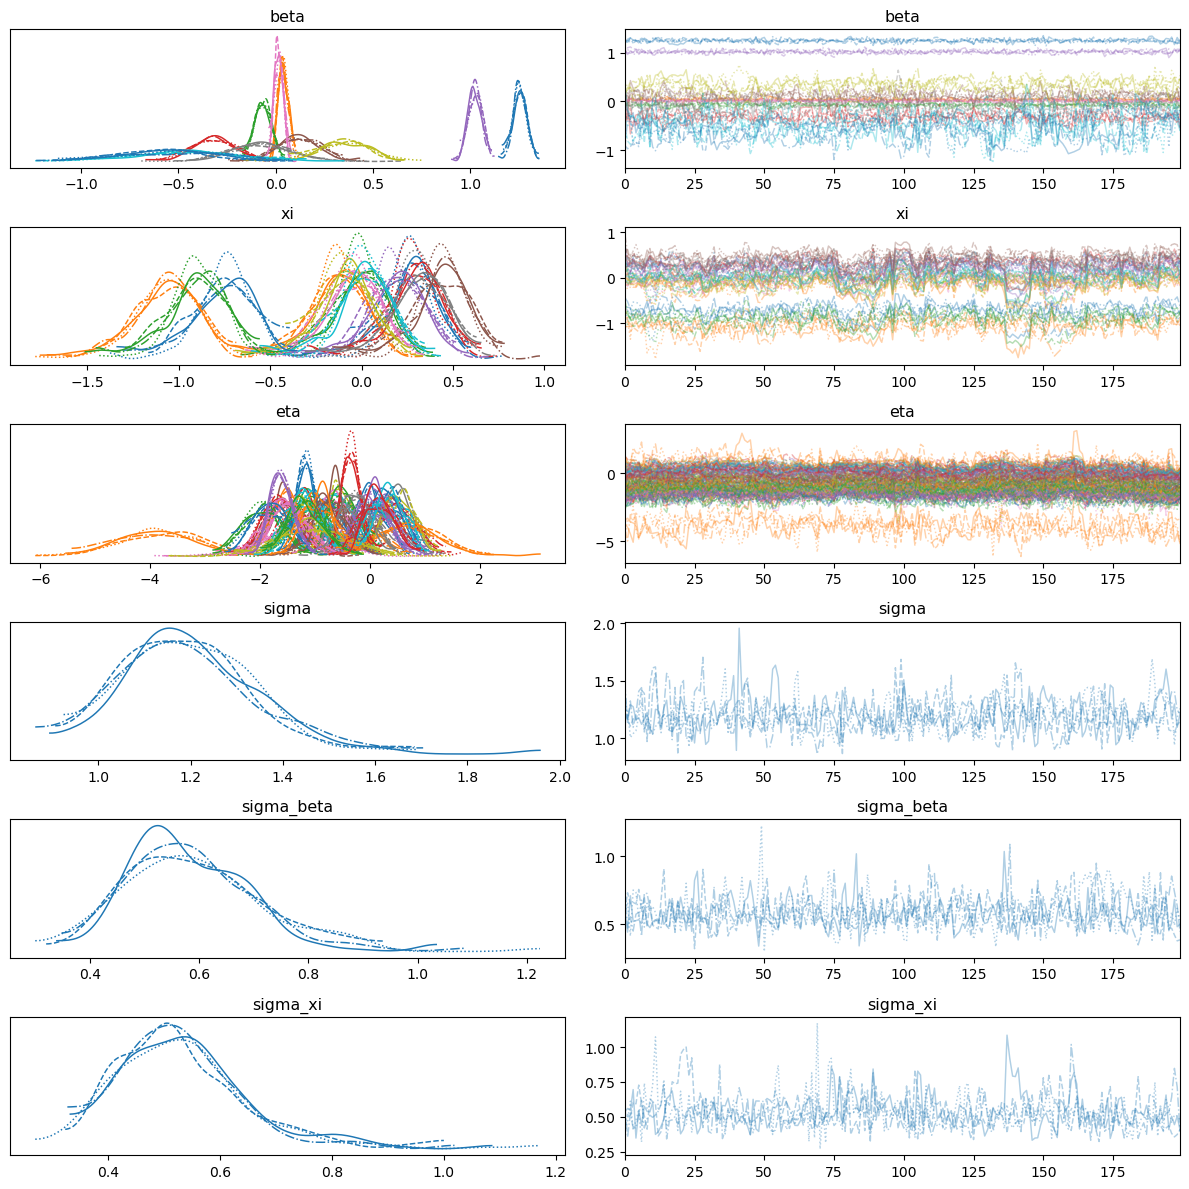

In [244]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'eta', 'sigma', 'sigma_beta', 'sigma_xi'])
plt.tight_layout()
plt.show()

In [245]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -3837.98    84.68
p_waic      104.65        -

There has been a warning during the calculation. Please check the results.
Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -3838.78    84.71
p_loo      105.45        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3803   99.9%
 (0.5, 0.7]   (ok)          5    0.1%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [246]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [247]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

Outliers:
[  74   78   84  125  150  160  187  193  233  347  365  372  384  402
  403  441  474  475  529  579  602  656  675  676  778  798  851  867
  872  873  907 1043 1078 1093 1122 1156 1157 1262 1279 1337 1366 1394
 1427 1524 1532 1539 1568 1618 1647 1658 1748 1780 1813 1821 1832 1878
 1935 1973 2110 2127 2135 2158 2224 2240 2330 2331 2338 2371 2377 2384
 2389 2440 2449 2492 2518 2532 2562 2569 2595 2615 2650 2672 2679 2691
 2705 2725 2750 2769 2817 2829 2851 2871 2877 2879 2911 2979 2997 3030
 3044 3087 3100 3185 3220 3222 3226 3227 3260 3272 3330 3361 3400 3401
 3443 3486 3507 3560 3610 3626 3663 3668 3743 3770]

The total number of outliers is: 122

The MSE is: 2.2326024159663866

The MAE is: 0.7199317226890757

The MAD is: 0.0

The percentage of observations inside the CI is: 0.9679621848739496



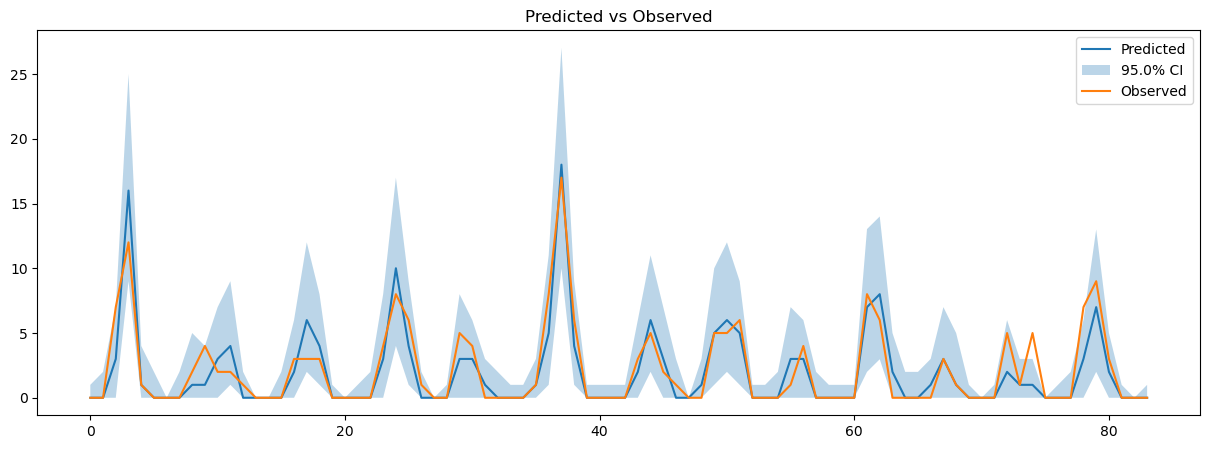

In [248]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()

In [249]:
Model_metrics.loc['Spatial',:] = [waic, loo, mse, mae, mad, percentage_inside]
print(Model_metrics)

                 WAIC          LOO       MSE       MAE  MAD inside CI
Base      -5432.83397 -5432.955864  5.283942  1.174238  0.0  0.917542
Years    -4815.305727  -4815.71997  4.036239  0.997111  0.0  0.933298
Stations -3838.954906 -3839.784293  2.234966   0.71678  0.0  0.968487
Spatial  -3837.981364 -3838.781993  2.232602  0.719932  0.0  0.967962


In [250]:
model_space_bis = FetchModel("space_bis").compile()

19:56:06 - cmdstanpy - INFO - compiling stan file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\space_bis.stan to exe file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\space_bis.exe
19:57:00 - cmdstanpy - INFO - compiled model executable: C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\space_bis.exe


In [251]:
data_space_bis = {
    "N": len(Y_obs),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "stations": stations_obs,
    "year": years_obs,
    "y": Y_obs['Count_180'],
    "X": X_obs,
    "phi": phi,
    "distances": distances
}

fit_space_bis = model_space_bis.sample(data=data_space_bis, chains=4, parallel_chains=4, 
    iter_warmup=200, iter_sampling=300)
posterior_180_space_bis = az.from_cmdstanpy(fit_space_bis)

19:57:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:59:30 - cmdstanpy - INFO - CmdStan done processing.
19:59:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: Matrix m is not positive definite (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space_bis.stan', line 36, column 4 to column 65)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space_bis.stan', line 36, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space_bis.stan', line 36, column 4 to column 65)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/space_bis.stan', line 36, column 4 to column 65)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf

In [252]:
post_pred = PostPred(posterior_180_space_bis, Y['Count_180'])
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

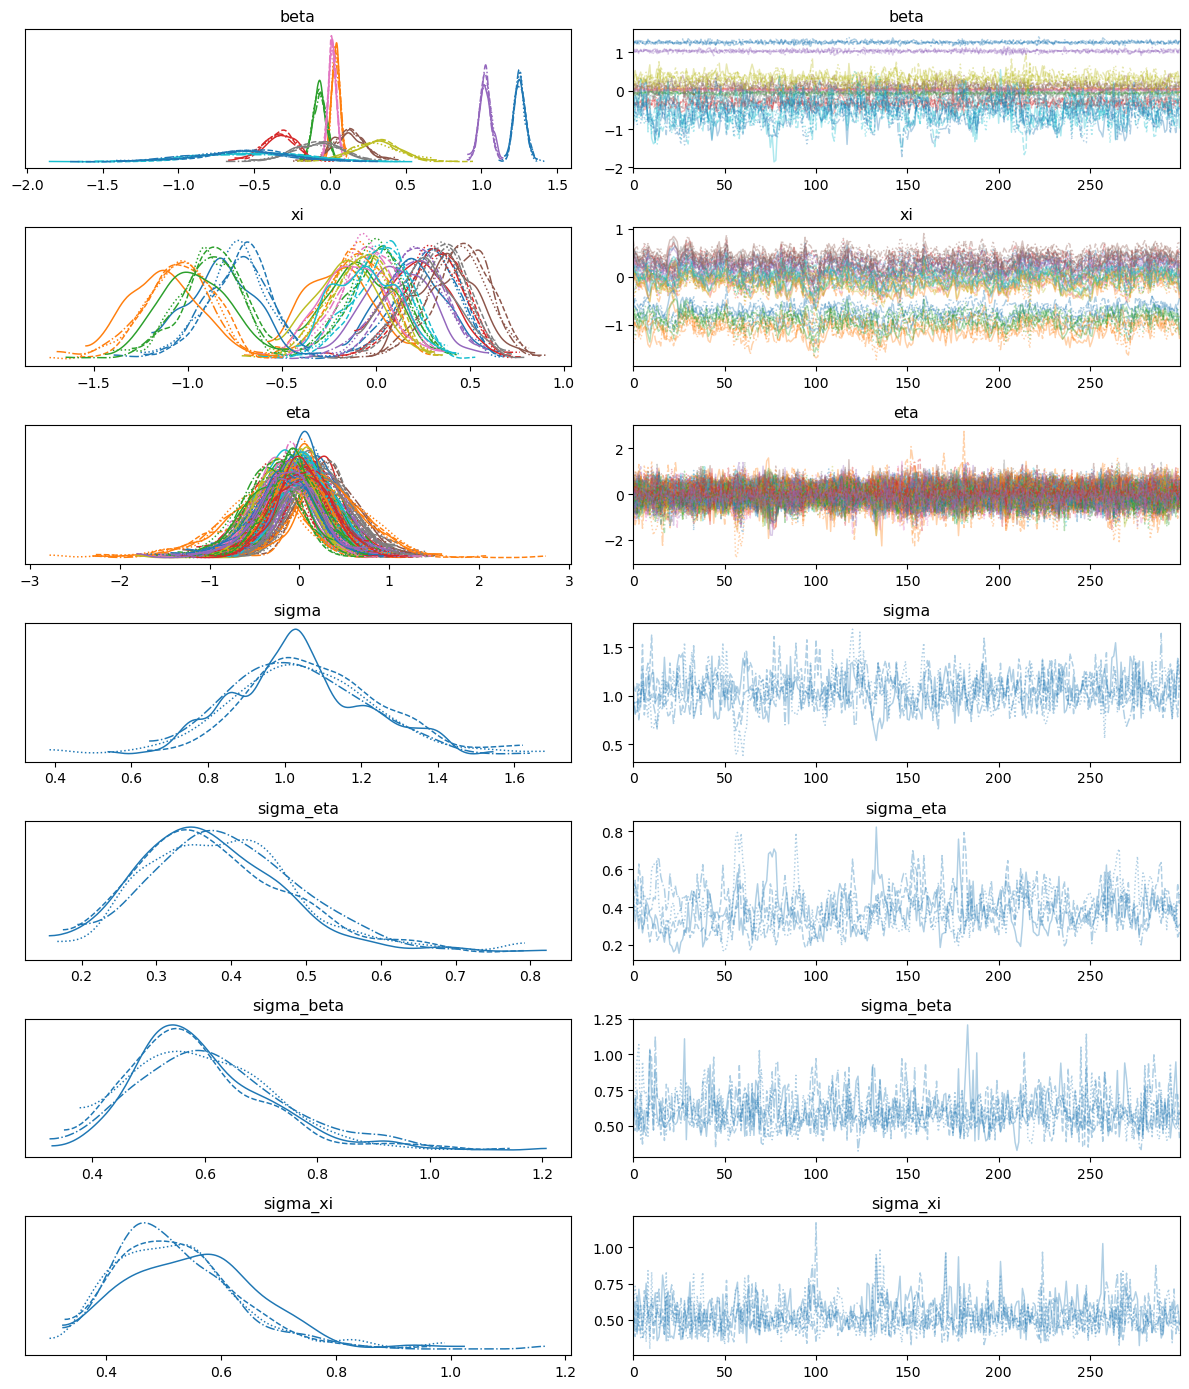

In [253]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'eta', 'sigma', 'sigma_eta', 'sigma_beta', 'sigma_xi'])
plt.tight_layout()
plt.show()

In [254]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 1200 posterior samples and 3808 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -3839.00    84.72
p_waic      106.08        -

There has been a warning during the calculation. Please check the results.
Computed from 1200 posterior samples and 3808 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -3839.73    84.75
p_loo      106.81        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3806   99.9%
 (0.5, 0.7]   (ok)          2    0.1%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [255]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [256]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

Outliers:
[  74  125  150  160  187  193  233  365  372  384  402  403  441  474
  475  529  579  602  656  675  676  778  798  872  873  907 1043 1078
 1093 1122 1156 1157 1262 1337 1366 1394 1427 1524 1532 1539 1568 1618
 1658 1748 1780 1813 1821 1832 1878 1935 1973 2110 2127 2135 2158 2224
 2240 2331 2338 2350 2371 2377 2384 2389 2440 2449 2458 2492 2518 2532
 2552 2561 2562 2569 2615 2646 2650 2672 2679 2691 2705 2725 2750 2769
 2817 2822 2829 2851 2877 2879 2911 2997 3030 3044 3087 3100 3185 3220
 3222 3226 3227 3260 3272 3330 3361 3375 3400 3401 3443 3507 3560 3610
 3626 3663 3668 3723 3743 3770]

The total number of outliers is: 118

The MSE is: 2.2478991596638656

The MAE is: 0.7205882352941176

The MAD is: 0.0

The percentage of observations inside the CI is: 0.9690126050420168



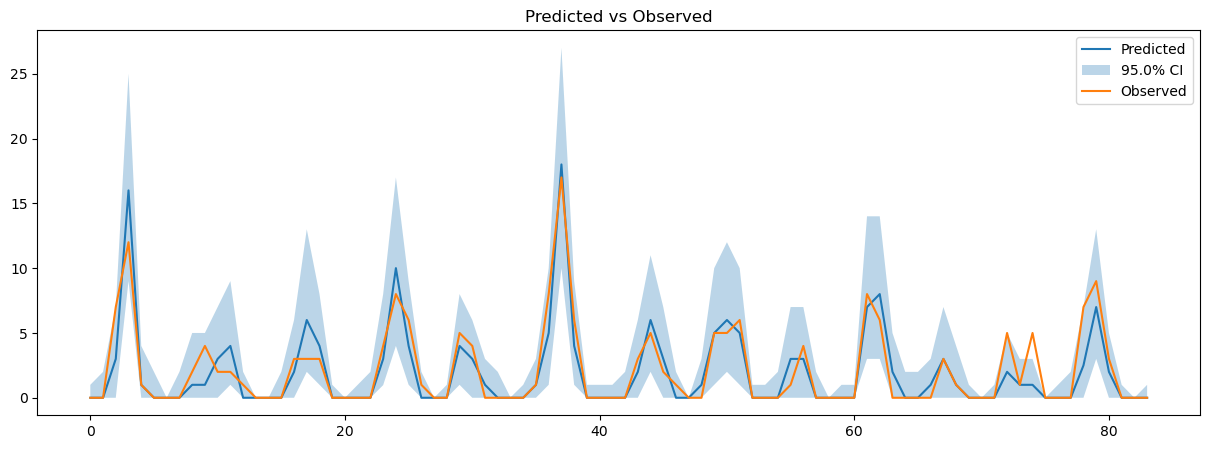

In [257]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()

In [258]:
Model_metrics.loc['Spatial 2',:] = [waic, loo, mse, mae, mad, percentage_inside]
print(Model_metrics)

                  WAIC          LOO       MSE       MAE  MAD inside CI
Base       -5432.83397 -5432.955864  5.283942  1.174238  0.0  0.917542
Years     -4815.305727  -4815.71997  4.036239  0.997111  0.0  0.933298
Stations  -3838.954906 -3839.784293  2.234966   0.71678  0.0  0.968487
Spatial   -3837.981364 -3838.781993  2.232602  0.719932  0.0  0.967962
Spatial 2  -3838.99894  -3839.72812  2.247899  0.720588  0.0  0.969013


# ZIP

In [259]:
model_zip = FetchModel("zip").compile()

20:00:25 - cmdstanpy - INFO - compiling stan file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\zip.stan to exe file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\zip.exe
20:02:35 - cmdstanpy - INFO - compiled model executable: C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\zip.exe


In [260]:
data_zip = {
    "N": len(Y_obs),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "stations": stations_obs,
    "year": years_obs,
    "y": Y_obs['Count_180'],
    "X": X_obs,
    "phi" : phi,
    "distances" : distances,
    "nmonths" : 7,
    "month" : months_obs
}

fit_zip = model_zip.sample(data=data_zip, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_180_zip = az.from_cmdstanpy(fit_zip)

20:02:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:12:11 - cmdstanpy - INFO - CmdStan done processing.
20:12:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: Matrix m is not positive definite (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/zip.stan', line 43, column 2 to column 63)
Exception: cholesky_decompose: Matrix m is not positive definite (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/zip.stan', line 43, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = nan, but A[2,1] = nan (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/zip.stan', line 43, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = nan, but A[2,1] = nan (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/zip.stan', line 43, column 2 to column 63)
Exception: cholesky_decompose: Matrix m is not positive definite (in 'C:/Users/matte/Desktop/Bayesian_St

In [261]:
post_pred = PostPred(posterior_180_zip, Y['Count_180'])
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

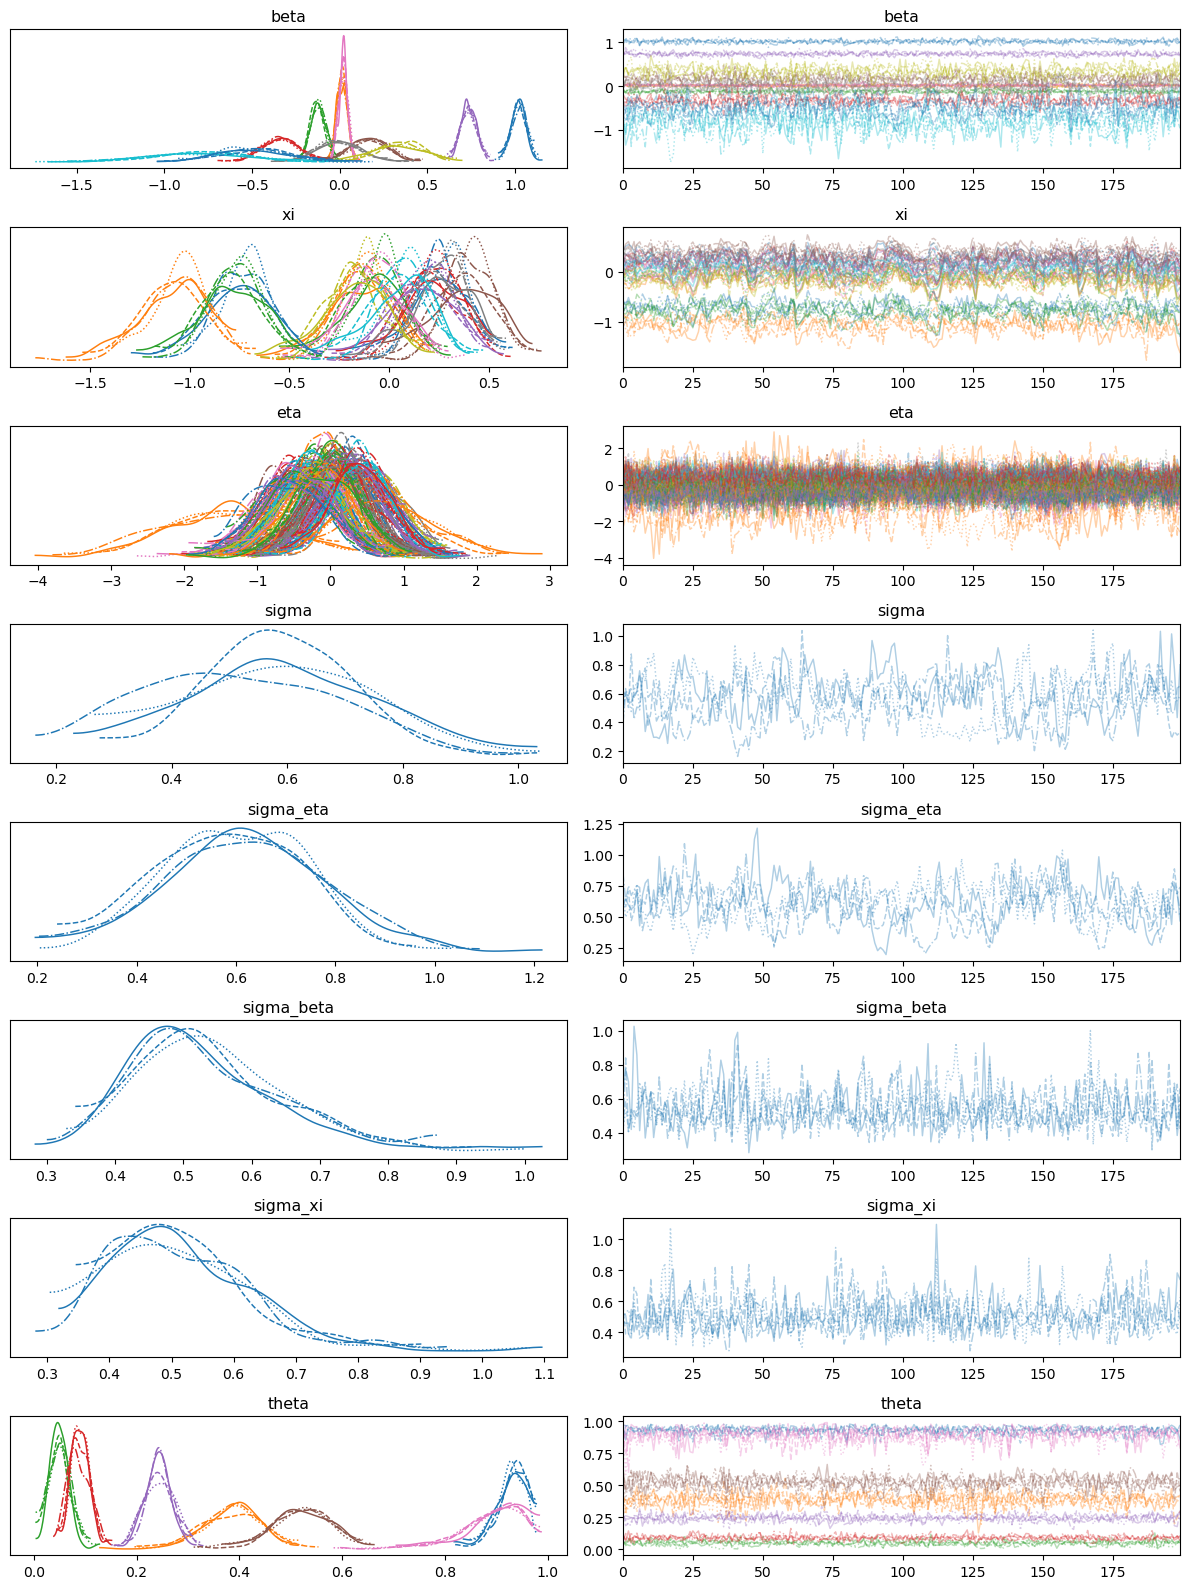

In [262]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'eta', 'sigma', 'sigma_eta', 'sigma_beta', 'sigma_xi', 'theta'])
plt.tight_layout()
plt.show()

In [263]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -3711.38    78.38
p_waic       97.52        -

There has been a warning during the calculation. Please check the results.
Computed from 800 posterior samples and 3808 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -3712.13    78.40
p_loo       98.27        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3806   99.9%
 (0.5, 0.7]   (ok)          2    0.1%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [264]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [265]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

Outliers:
[  74  150  187  233  372  384  402  403  441  474  475  529  579  596
  602  656  676  798  851  872  873 1093 1122 1156 1337 1366 1539 1568
 1658 1748 1813 1832 1878 1973 2110 2127 2135 2224 2240 2338 2371 2389
 2440 2449 2518 2532 2563 2569 2672 2705 2750 2769 2851 2877 2879 2997
 3030 3087 3100 3220 3222 3227 3324 3330 3400 3401 3443 3560 3610 3626
 3663 3711 3722 3743]

The total number of outliers is: 74

The MSE is: 2.177521008403361

The MAE is: 0.7190126050420168

The MAD is: 0.0

The percentage of observations inside the CI is: 0.9805672268907563



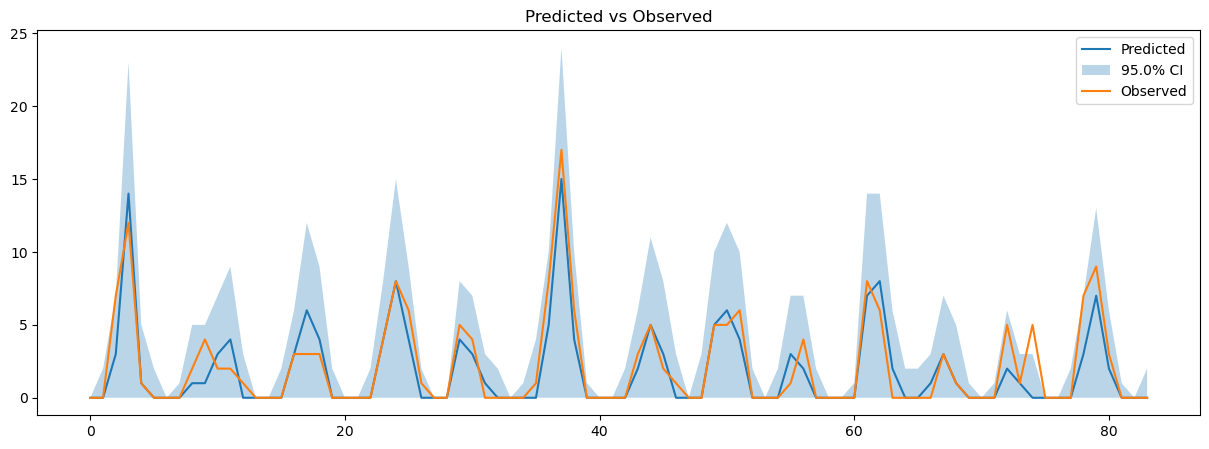

In [266]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()

In [267]:
Model_metrics.loc['ZIP',:] = [waic, loo, mse, mae, mad, percentage_inside]
print(Model_metrics)

                  WAIC          LOO       MSE       MAE  MAD inside CI
Base       -5432.83397 -5432.955864  5.283942  1.174238  0.0  0.917542
Years     -4815.305727  -4815.71997  4.036239  0.997111  0.0  0.933298
Stations  -3838.954906 -3839.784293  2.234966   0.71678  0.0  0.968487
Spatial   -3837.981364 -3838.781993  2.232602  0.719932  0.0  0.967962
Spatial 2  -3838.99894  -3839.72812  2.247899  0.720588  0.0  0.969013
ZIP       -3711.380094 -3712.131369  2.177521  0.719013  0.0  0.980567
